In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")
print(f"Statsmodels version: {sm.__version__}")

Libraries loaded successfully!
Statsmodels version: 0.14.5


In [33]:
df = pd.read_csv('../data/DE.csv', parse_dates=['timestamp'], index_col='timestamp')

print(f"Data shape: {df.shape}")
print(f"Date range: {df.index[0]} to {df.index[-1]}")
print(f"\nColumns: {list(df.columns)}")

load = df['load']
print(f"\nLoad statistics:")
print(load.describe())

Data shape: (19972, 3)
Date range: 2015-01-01 00:00:00+00:00 to 2017-04-12 03:00:00+00:00

Columns: ['load', 'solar', 'wind']

Load statistics:
count    19972.000000
mean     55598.950731
std      10053.214523
min      31307.000000
25%      47106.000000
50%      55229.000000
75%      64660.750000
max      76602.000000
Name: load, dtype: float64


In [34]:
def check_stationarity(timeseries, title):
    """Perform Augmented Dickey-Fuller test for stationarity"""
    print(f"\n{'='*60}")
    print(f"Stationarity Test: {title}")
    print('='*60)
    
    result = adfuller(timeseries.dropna(), autolag='AIC')
    
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print(f"\n Result: STATIONARY (p-value = {result[1]:.6f} <= 0.05)")
        print("    → Can use in ARIMA model")
    else:
        print(f"\n Result: NON-STATIONARY (p-value = {result[1]:.6f} > 0.05)")
        print("    → Needs differencing")
    
    return result[1] <= 0.05

In [35]:
subset = load.iloc[-30*24:]

is_stationary = check_stationarity(subset, "Original Load Data")


Stationarity Test: Original Load Data
ADF Statistic: -1.873810
p-value: 0.344480
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569

 Result: NON-STATIONARY (p-value = 0.344480 > 0.05)
    → Needs differencing


In [36]:
# Apply first-order differencing (d=1)
diff1 = subset.diff().dropna()
is_stationary_diff1 = check_stationarity(diff1, "After 1st Differencing (d=1)")


Stationarity Test: After 1st Differencing (d=1)
ADF Statistic: -10.588267
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569

 Result: STATIONARY (p-value = 0.000000 <= 0.05)
    → Can use in ARIMA model


In [37]:
# Apply seasonal differencing (D=1, s=24)
seasonal_diff = subset.diff(24).dropna()
is_stationary_seasonal = check_stationarity(seasonal_diff, "After Seasonal Differencing (D=1, s=24)")


Stationarity Test: After Seasonal Differencing (D=1, s=24)
ADF Statistic: -5.288608
p-value: 0.000006
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569

 Result: STATIONARY (p-value = 0.000006 <= 0.05)
    → Can use in ARIMA model


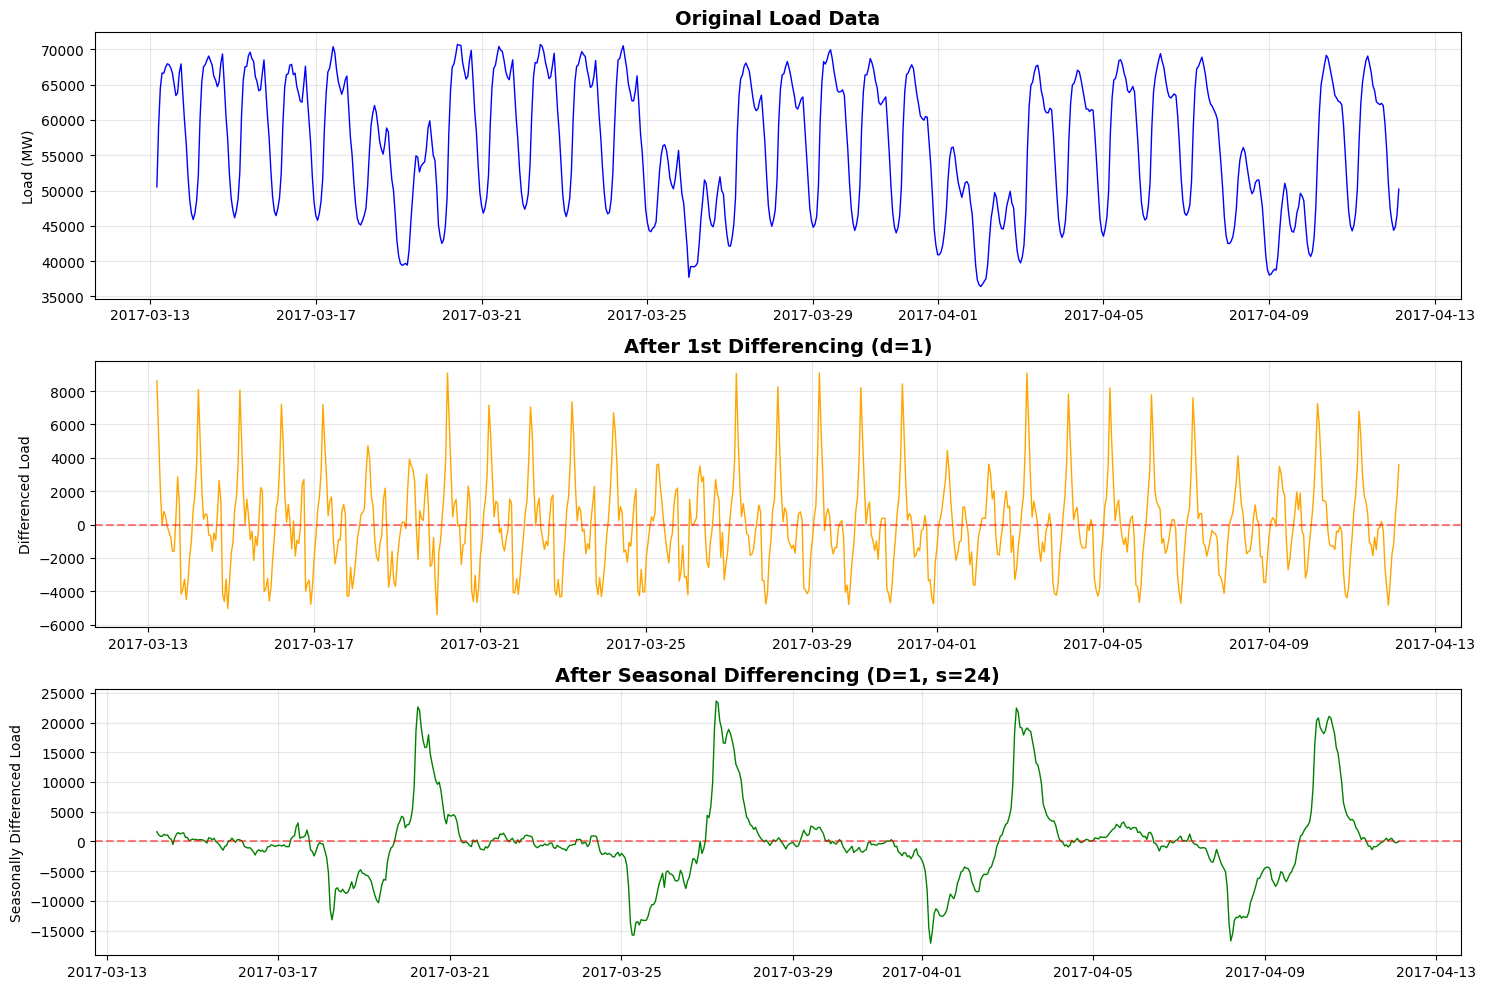


Differencing makes the data stationary by removing trends and seasonality


In [38]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Original
axes[0].plot(subset.index, subset.values, color='blue', linewidth=1)
axes[0].set_title('Original Load Data', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Load (MW)')
axes[0].grid(True, alpha=0.3)

# First difference
axes[1].plot(diff1.index, diff1.values, color='orange', linewidth=1)
axes[1].set_title('After 1st Differencing (d=1)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Differenced Load')
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1].grid(True, alpha=0.3)

# Seasonal difference
axes[2].plot(seasonal_diff.index, seasonal_diff.values, color='green', linewidth=1)
axes[2].set_title('After Seasonal Differencing (D=1, s=24)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Seasonally Differenced Load')
axes[2].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/sarima_stationarity.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nDifferencing makes the data stationary by removing trends and seasonality")

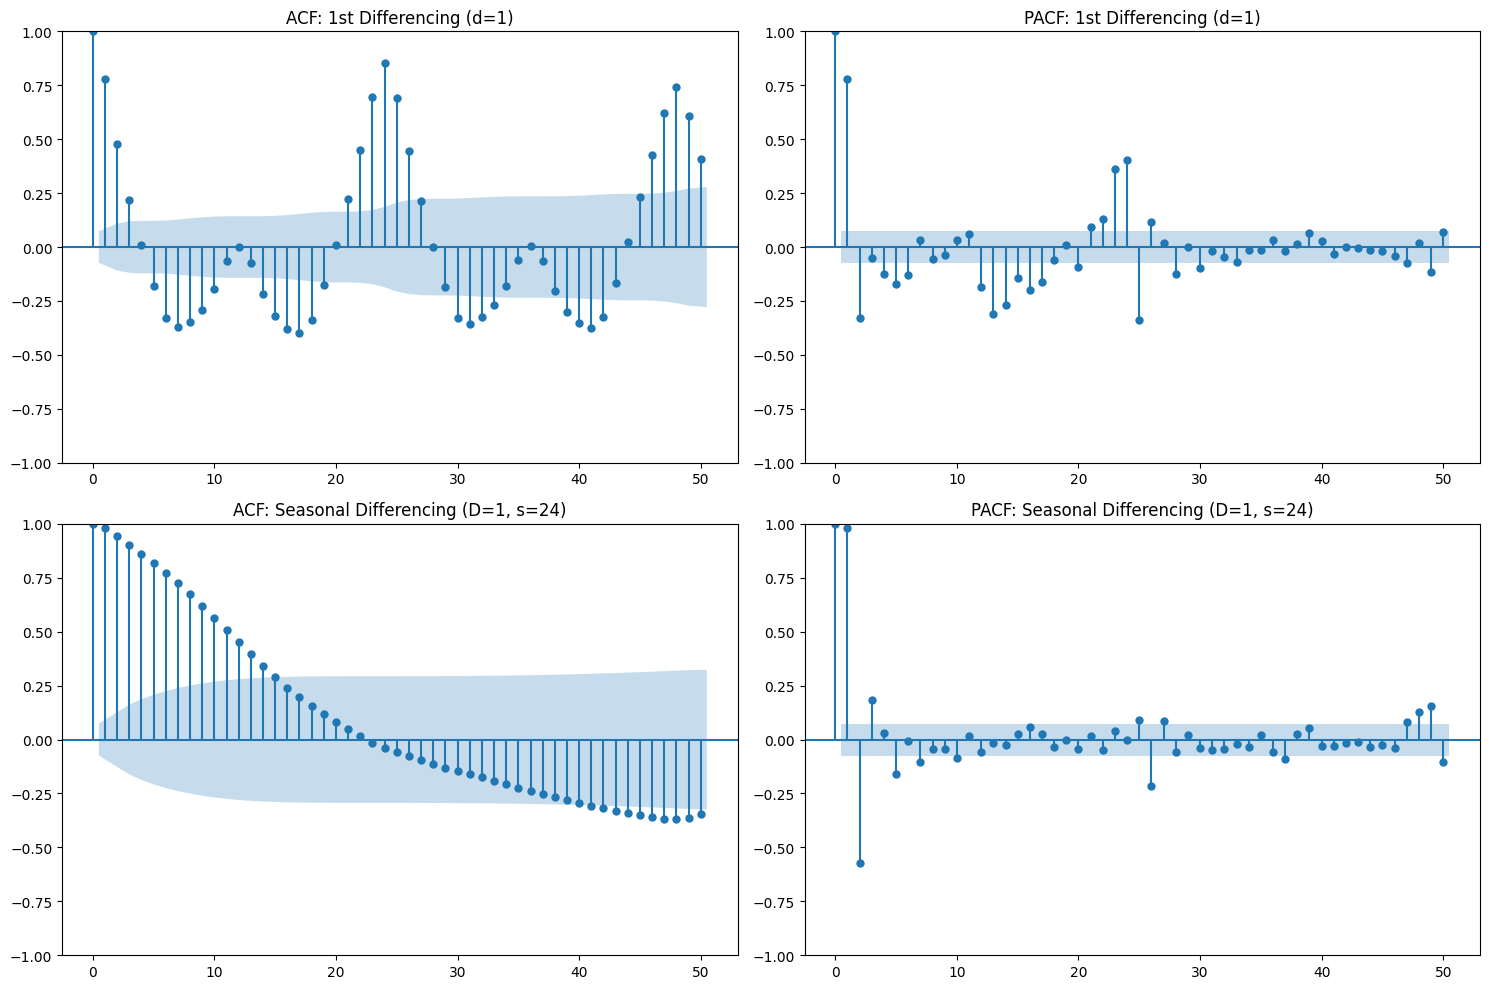


Interpretation:
   - ACF shows significant lags → suggests MA (q) component
   - PACF shows significant lags → suggests AR (p) component
   - Spikes at multiples of 24 → confirms daily seasonality (s=24)


In [39]:
# ACF and PACF after differencing
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# First differencing
plot_acf(diff1, lags=50, ax=axes[0, 0], title='ACF: 1st Differencing (d=1)')
plot_pacf(diff1, lags=50, ax=axes[0, 1], title='PACF: 1st Differencing (d=1)')

# Seasonal differencing
plot_acf(seasonal_diff, lags=50, ax=axes[1, 0], title='ACF: Seasonal Differencing (D=1, s=24)')
plot_pacf(seasonal_diff, lags=50, ax=axes[1, 1], title='PACF: Seasonal Differencing (D=1, s=24)')

plt.tight_layout()
plt.savefig('../outputs/sarima_acf_pacf.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nInterpretation:")
print("   - ACF shows significant lags → suggests MA (q) component")
print("   - PACF shows significant lags → suggests AR (p) component")
print("   - Spikes at multiples of 24 → confirms daily seasonality (s=24)")

In [40]:
train_days = 90
train_data = load.iloc[-train_days*24:]

print(f"Training data shape: {train_data.shape}")
print(f"Training period: {train_data.index[0]} to {train_data.index[-1]}")
print(f"Mean load: {train_data.mean():.2f} MW")
print(f"Std load: {train_data.std():.2f} MW")

Training data shape: (2160,)
Training period: 2017-01-12 04:00:00+00:00 to 2017-04-12 03:00:00+00:00
Mean load: 59300.17 MW
Std load: 9677.58 MW


In [41]:
order = (2, 1, 2)
seasonal_order = (1, 1, 1, 24)

print("Building SARIMA Model...")
print(f"  Order (p,d,q): {order}")
print(f"  Seasonal Order (P,D,Q,s): {seasonal_order}")


Building SARIMA Model...
  Order (p,d,q): (2, 1, 2)
  Seasonal Order (P,D,Q,s): (1, 1, 1, 24)


In [42]:
# Create the SARIMA model
model = SARIMAX(
    train_data,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,  # Allow flexibility
    enforce_invertibility=False  # Allow flexibility
)

print("Model created successfully!")
print(f"\nModel specification: SARIMAX{order}x{seasonal_order}")

Model created successfully!

Model specification: SARIMAX(2, 1, 2)x(1, 1, 1, 24)


### Step 5.3: Fit the Model

In [44]:
%%time
# Fit the model
print("Fitting SARIMA model...")

model_fit = model.fit(
    disp=False,        
    maxiter=50,        
    method='lbfgs'     
)

print("\n Model fitted successfully!")

Fitting SARIMA model...

 Model fitted successfully!
CPU times: user 8.21 s, sys: 88.8 ms, total: 8.29 s
Wall time: 8.32 s

 Model fitted successfully!
CPU times: user 8.21 s, sys: 88.8 ms, total: 8.29 s
Wall time: 8.32 s


In [45]:
# Full model summary
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                 load   No. Observations:                 2160
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 24)   Log Likelihood              -17273.213
Date:                              Fri, 21 Nov 2025   AIC                          34560.426
Time:                                      12:11:58   BIC                          34600.000
Sample:                                  01-12-2017   HQIC                         34574.918
                                       - 04-12-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5476      0.065      8.453      0.000       0.421       0.675
ar.L2         -0.27

In [46]:
# Extract key statistics
print("\n" + "="*60)
print("KEY MODEL STATISTICS")
print("="*60)

print(f"\n Information Criteria:")
print(f"   AIC:  {model_fit.aic:.2f}")
print(f"   BIC:  {model_fit.bic:.2f}")
print(f"   (Lower is better)")

print(f"\n Log-Likelihood: {model_fit.llf:.2f}")
print(f"   (Higher is better)")

print(f"\n Number of Observations: {model_fit.nobs}")
print(f"   Training hours: {model_fit.nobs} hours ({model_fit.nobs/24:.1f} days)")

print(f"\n Number of Parameters: {len(model_fit.params)}")
print(f"   AR parameters: {order[0]}")
print(f"   MA parameters: {order[2]}")
print(f"   Seasonal AR: {seasonal_order[0]}")
print(f"   Seasonal MA: {seasonal_order[2]}")


KEY MODEL STATISTICS

 Information Criteria:
   AIC:  34560.43
   BIC:  34600.00
   (Lower is better)

 Log-Likelihood: -17273.21
   (Higher is better)

 Number of Observations: 2160
   Training hours: 2160 hours (90.0 days)

 Number of Parameters: 7
   AR parameters: 2
   MA parameters: 2
   Seasonal AR: 1
   Seasonal MA: 1


In [47]:
# Display all parameters
params_df = pd.DataFrame({
    'Parameter': model_fit.params.index,
    'Coefficient': model_fit.params.values,
    'Std Error': model_fit.bse.values,
    'z-value': model_fit.tvalues.values,
    'p-value': model_fit.pvalues.values
})

print("\nModel Parameters:")
print(params_df.to_string(index=False))

# Highlight significant parameters (p < 0.05)
significant = params_df[params_df['p-value'] < 0.05]
print(f"\n Significant parameters (p < 0.05): {len(significant)}/{len(params_df)}")


Model Parameters:
Parameter   Coefficient    Std Error    z-value       p-value
    ar.L1      0.547601     0.064779   8.453385  2.829776e-17
    ar.L2     -0.271988     0.038734  -7.022046  2.186425e-12
    ma.L1      0.224166     0.062613   3.580190  3.433442e-04
    ma.L2      0.158360     0.038419   4.121948  3.756814e-05
 ar.S.L24      0.304854     0.013081  23.304411 3.999454e-120
 ma.S.L24     -0.882003     0.010899 -80.924381  0.000000e+00
   sigma2 755496.291219 13864.865523  54.489983  0.000000e+00

 Significant parameters (p < 0.05): 7/7


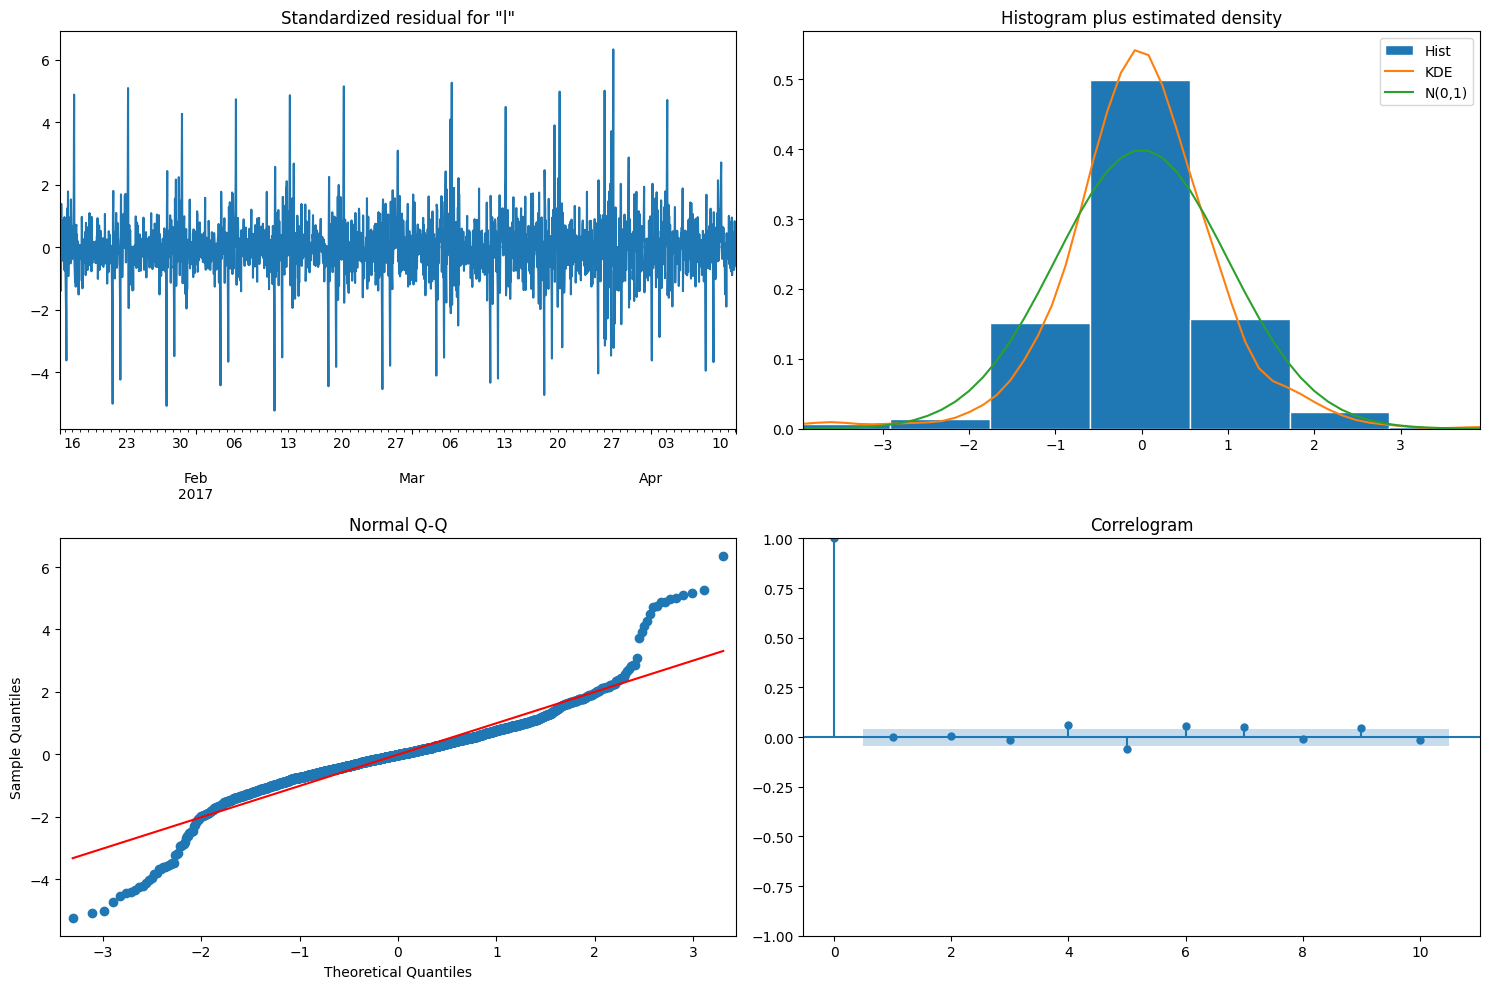

In [48]:
# SARIMA diagnostic plots
fig = model_fit.plot_diagnostics(figsize=(15, 10))
plt.tight_layout()
plt.savefig('../outputs/sarima_diagnostics.png', dpi=300, bbox_inches='tight')
plt.show()



In [18]:
# Forecast next 24 hours
forecast_steps = 24
forecast_result = model_fit.get_forecast(steps=forecast_steps)

# Get predictions and confidence intervals
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int(alpha=0.2)  # 80% confidence interval

print(f"Forecast for next {forecast_steps} hours:")
print(f"\nFirst 5 predictions:")
print(forecast_mean.head())

print(f"\nForecast range:")
print(f"   Min: {forecast_mean.min():.2f} MW")
print(f"   Max: {forecast_mean.max():.2f} MW")
print(f"   Mean: {forecast_mean.mean():.2f} MW")

Forecast for next 24 hours:

First 5 predictions:
2017-04-12 04:00:00+00:00    56444.468589
2017-04-12 05:00:00+00:00    61352.993794
2017-04-12 06:00:00+00:00    64507.369315
2017-04-12 07:00:00+00:00    66125.110205
2017-04-12 08:00:00+00:00    67394.258553
Freq: h, Name: predicted_mean, dtype: float64

Forecast range:
   Min: 45950.07 MW
   Max: 68325.91 MW
   Mean: 58958.54 MW


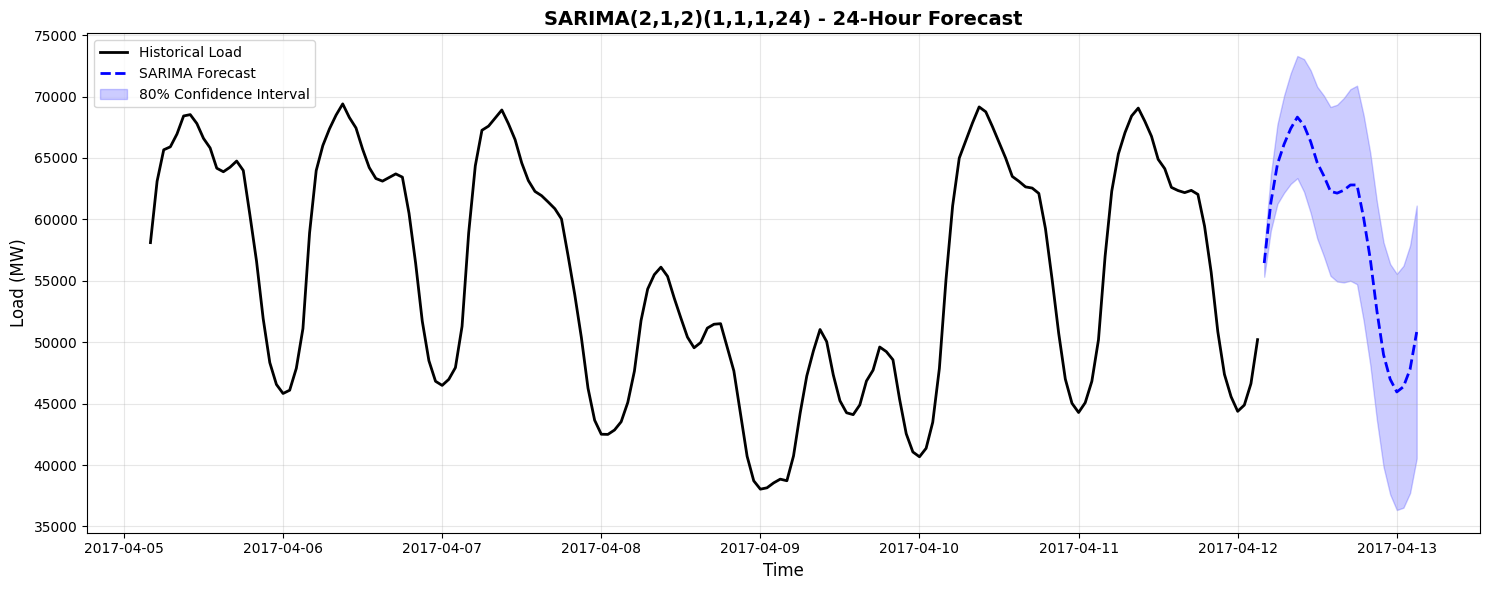

In [19]:
# Visualize forecast
fig, ax = plt.subplots(figsize=(15, 6))

# Historical data (last 7 days)
history_window = 7 * 24
ax.plot(train_data.iloc[-history_window:].index, 
        train_data.iloc[-history_window:].values, 
        label='Historical Load', color='black', linewidth=2)

# Forecast
forecast_index = pd.date_range(
    start=train_data.index[-1] + pd.Timedelta(hours=1),
    periods=forecast_steps,
    freq='h'
)

ax.plot(forecast_index, forecast_mean.values, 
        label='SARIMA Forecast', color='blue', linewidth=2, linestyle='--')

# Confidence interval
ax.fill_between(forecast_index, 
                forecast_ci.iloc[:, 0], 
                forecast_ci.iloc[:, 1],
                color='blue', alpha=0.2, label='80% Confidence Interval')

ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Load (MW)', fontsize=12)
ax.set_title('SARIMA(2,1,2)(1,1,1,24) - 24-Hour Forecast', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/sarima_forecast.png', dpi=300, bbox_inches='tight')
plt.show()


FORECAST ACCURACY METRICS
MAE:   7585.80 MW
RMSE:  8707.51 MW
MAPE:  12.87%


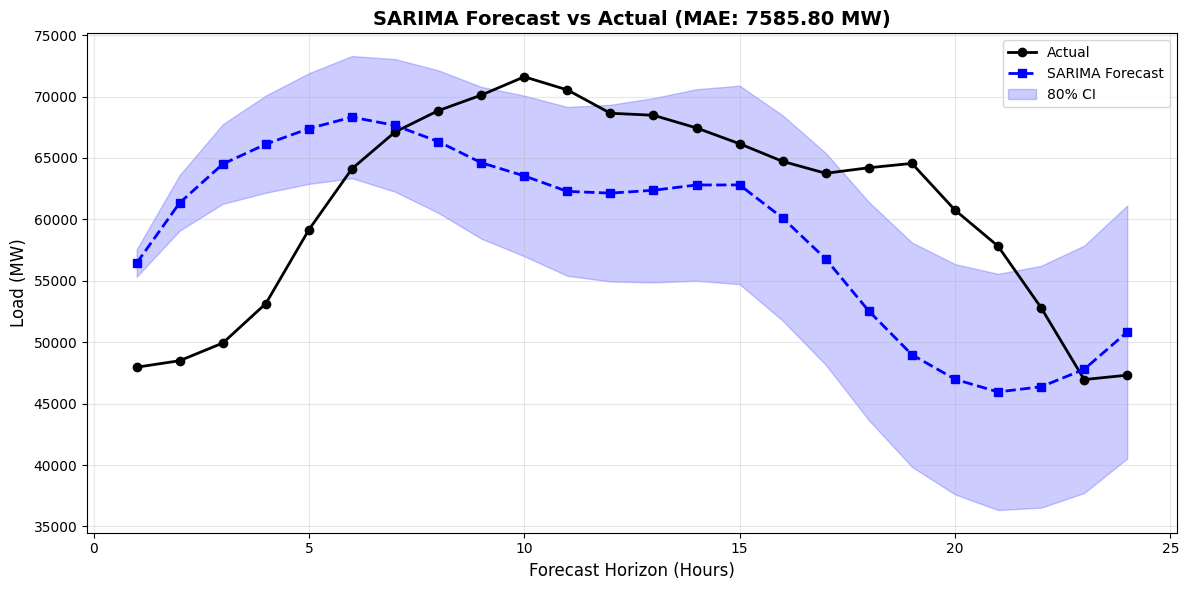

In [20]:
# If we have actual future values (from test set)
if len(load) > len(train_data) + forecast_steps:
    actual_future = load.iloc[len(train_data):len(train_data)+forecast_steps]
    
    # Calculate errors
    errors = actual_future.values - forecast_mean.values
    mae = np.abs(errors).mean()
    rmse = np.sqrt((errors**2).mean())
    mape = (np.abs(errors / actual_future.values) * 100).mean()
    
    print("\n" + "="*60)
    print("FORECAST ACCURACY METRICS")
    print("="*60)
    print(f"MAE:   {mae:.2f} MW")
    print(f"RMSE:  {rmse:.2f} MW")
    print(f"MAPE:  {mape:.2f}%")
    
    # Visualize actual vs predicted
    fig, ax = plt.subplots(figsize=(12, 6))
    
    hours = np.arange(1, forecast_steps + 1)
    ax.plot(hours, actual_future.values, 'o-', label='Actual', color='black', linewidth=2, markersize=6)
    ax.plot(hours, forecast_mean.values, 's--', label='SARIMA Forecast', color='blue', linewidth=2, markersize=6)
    
    ax.fill_between(hours, 
                    forecast_ci.iloc[:, 0], 
                    forecast_ci.iloc[:, 1],
                    color='blue', alpha=0.2, label='80% CI')
    
    ax.set_xlabel('Forecast Horizon (Hours)', fontsize=12)
    ax.set_ylabel('Load (MW)', fontsize=12)
    ax.set_title(f'SARIMA Forecast vs Actual (MAE: {mae:.2f} MW)', fontsize=14, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/sarima_forecast_vs_actual.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("\nNo future data available for validation.")

## 11. Model Architecture Summary

Let's create a comprehensive summary similar to a neural network summary.

In [ ]:
def print_sarima_architecture(model_fit, order, seasonal_order):
    """Print detailed SARIMA model architecture"""
    
    
    print("\n MODEL SPECIFICATION:")
    print(f"   Full notation: SARIMA{order}x{seasonal_order}")
    
    print("\n COMPONENTS:")
    print(f"   ├─ NON-SEASONAL PART (p,d,q) = {order}")
    print(f"   │  ├─ AR(p={order[0]}): Uses {order[0]} lagged observations")
    print(f"   │  ├─ I(d={order[1]}): Differencing order {order[1]}")
    print(f"   │  └─ MA(q={order[2]}): Uses {order[2]} lagged forecast errors")
    print(f"   │")
    print(f"   └─ SEASONAL PART (P,D,Q,s) = {seasonal_order}")
    print(f"      ├─ SAR(P={seasonal_order[0]}): Uses observation {seasonal_order[3]} hours ago")
    print(f"      ├─ SI(D={seasonal_order[1]}): Seasonal differencing order {seasonal_order[1]}")
    print(f"      ├─ SMA(Q={seasonal_order[2]}): Uses seasonal error {seasonal_order[3]} hours ago")
    print(f"      └─ s={seasonal_order[3]}: Seasonality period (daily cycle)")
    
    print("\n PARAMETERS:")
    total_params = len(model_fit.params)
    print(f"   Total parameters: {total_params}")
    print(f"   ├─ AR coefficients: {order[0]}")
    print(f"   ├─ MA coefficients: {order[2]}")
    print(f"   ├─ Seasonal AR: {seasonal_order[0]}")
    print(f"   ├─ Seasonal MA: {seasonal_order[2]}")
    print(f"   └─ Other (variance, etc.): {total_params - order[0] - order[2] - seasonal_order[0] - seasonal_order[2]}")
    
    print("\n TRAINING INFO:")
    print(f"   Observations: {model_fit.nobs} hours ({model_fit.nobs/24:.1f} days)")
    print(f"   Log-Likelihood: {model_fit.llf:.2f}")
    print(f"   AIC: {model_fit.aic:.2f}")
    print(f"   BIC: {model_fit.bic:.2f}")
    
    print("\n🎯 MODEL EQUATION (Simplified):")
    print(f"   y(t) = φ₁·y(t-1) + φ₂·y(t-2)              [AR part]")
    print(f"        + Φ₁·y(t-24)                         [Seasonal AR]")
    print(f"        + θ₁·ε(t-1) + θ₂·ε(t-2)              [MA part]")
    print(f"        + Θ₁·ε(t-24)                         [Seasonal MA]")
    print(f"        + ε(t)                               [White noise]")
    print(f"\n   Where:")
    print(f"   - y(t) is the differenced series (d={order[1]}, D={seasonal_order[1]})")
    print(f"   - φ are AR coefficients")
    print(f"   - Φ are seasonal AR coefficients")
    print(f"   - θ are MA coefficients")
    print(f"   - Θ are seasonal MA coefficients")
    print(f"   - ε are error terms")
    
    print("\n" + "="*70)

# Print the architecture
print_sarima_architecture(model_fit, order, seasonal_order)


                    SARIMA MODEL ARCHITECTURE

📋 MODEL SPECIFICATION:
   Full notation: SARIMA(2, 1, 2)x(1, 1, 1, 24)
   Expanded: SARIMA(2,1,2)x(1,1,1,24)

🔧 COMPONENTS:
   ├─ NON-SEASONAL PART (p,d,q) = (2, 1, 2)
   │  ├─ AR(p=2): Uses 2 lagged observations
   │  ├─ I(d=1): Differencing order 1
   │  └─ MA(q=2): Uses 2 lagged forecast errors
   │
   └─ SEASONAL PART (P,D,Q,s) = (1, 1, 1, 24)
      ├─ SAR(P=1): Uses observation 24 hours ago
      ├─ SI(D=1): Seasonal differencing order 1
      ├─ SMA(Q=1): Uses seasonal error 24 hours ago
      └─ s=24: Seasonality period (daily cycle)

📊 PARAMETERS:
   Total parameters: 7
   ├─ AR coefficients: 2
   ├─ MA coefficients: 2
   ├─ Seasonal AR: 1
   ├─ Seasonal MA: 1
   └─ Other (variance, etc.): 1

📈 TRAINING INFO:
   Observations: 2160 hours (90.0 days)
   Log-Likelihood: -17273.21
   AIC: 34560.43
   BIC: 34600.00

🎯 MODEL EQUATION (Simplified):
   y(t) = φ₁·y(t-1) + φ₂·y(t-2)              [AR part]
        + Φ₁·y(t-24)               

## 12. Save Model for Later Use

In [22]:
import pickle

# Save the fitted model
model_path = '../outputs/sarima_model_DE.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(model_fit, f)

print(f"✅ Model saved to: {model_path}")
print(f"\nTo load later:")
print("   with open('sarima_model_DE.pkl', 'rb') as f:")
print("       loaded_model = pickle.load(f)")

✅ Model saved to: ../outputs/sarima_model_DE.pkl

To load later:
   with open('sarima_model_DE.pkl', 'rb') as f:
       loaded_model = pickle.load(f)


In [49]:
# Load live forecast results for Germany
live_forecasts = pd.read_csv('../outputs/DE_live_forecasts.csv', parse_dates=['timestamp'])

print(f"Live forecasts shape: {live_forecasts.shape}")
print(f"Period: {live_forecasts['timestamp'].min()} to {live_forecasts['timestamp'].max()}")
print(f"\nColumns: {list(live_forecasts.columns)}")

# Remove any rows with missing values
live_forecasts = live_forecasts.dropna(subset=['y_true', 'yhat'])

print(f"\nValid forecasts: {len(live_forecasts)} points")

Live forecasts shape: (1998, 3)
Period: 2017-01-18 22:00:00+00:00 to 2017-04-12 03:00:00+00:00

Columns: ['timestamp', 'y_true', 'yhat']

Valid forecasts: 1998 points


In [50]:
# Extract actual and predicted values
y_true = live_forecasts['y_true'].values
y_pred = live_forecasts['yhat'].values

# Calculate all metrics
errors = y_true - y_pred

# Standard metrics
mae = np.abs(errors).mean()
rmse = np.sqrt((errors**2).mean())
mape = (np.abs(errors / y_true) * 100).mean()

# sMAPE (Symmetric Mean Absolute Percentage Error)
smape = (100 / len(y_true)) * np.sum(
    np.abs(y_pred - y_true) / 
    ((np.abs(y_true) + np.abs(y_pred)) / 2)
)

# MASE (Mean Absolute Scaled Error)
# For seasonal data, use seasonal naive forecast (lag 24)
# Load original data to calculate naive MAE
df_original = pd.read_csv('../data/DE.csv', parse_dates=['timestamp'], index_col='timestamp')
load_series = df_original['load']

# Calculate naive forecast error (using 24-hour lag)
naive_errors = load_series.diff(24).dropna()
mae_naive = np.abs(naive_errors).mean()

mase = mae / mae_naive if mae_naive > 0 else np.nan

# Print comprehensive results
print("\n" + "="*70)
print(" "*20 + "SARIMA MODEL PERFORMANCE")
print("="*70)

print("\n FORECAST ACCURACY METRICS:")
print(f"\n   MAE:    {mae:>10.2f} MW")
print(f"   RMSE:   {rmse:>10.2f} MW")
print(f"   MAPE:   {mape:>10.2f} %")
print(f"   sMAPE:  {smape:>10.2f} %")
print(f"   MASE:   {mase:>10.4f}")

print("\n" + "-"*70)
print("\n INTERPRETATION:")
print(f"\n    MAE = {mae:.2f} MW")
print(f"      → Average error is {mae:.2f} MW per forecast")

print(f"\n    sMAPE = {smape:.2f}%")
if smape < 5:
    print(f"      → Excellent! Under 5% is very good for load forecasting")
elif smape < 10:
    print(f"      → Good performance for load forecasting")
else:
    print(f"      → Room for improvement")

print(f"\n    MASE = {mase:.4f}")
if mase < 0.5:
    print(f"      → Excellent! Much better than naive forecast")
elif mase < 1.0:
    print(f"      → Good! Better than naive forecast")
else:
    print(f"      → Worse than naive forecast (needs improvement)")

print(f"\n    Baseline Comparison:")
print(f"      Naive MAE (24h lag): {mae_naive:.2f} MW")
print(f"      SARIMA improvement: {((1 - mase) * 100):.1f}% better than naive")

print("\n" + "="*70)


                    SARIMA MODEL PERFORMANCE

 FORECAST ACCURACY METRICS:

   MAE:       3559.21 MW
   RMSE:      4988.63 MW
   MAPE:         6.18 %
   sMAPE:        6.13 %
   MASE:       0.7986

----------------------------------------------------------------------

 INTERPRETATION:

    MAE = 3559.21 MW
      → Average error is 3559.21 MW per forecast

    sMAPE = 6.13%
      → Good performance for load forecasting

    MASE = 0.7986
      → Good! Better than naive forecast

    Baseline Comparison:
      Naive MAE (24h lag): 4456.88 MW
      SARIMA improvement: 20.1% better than naive



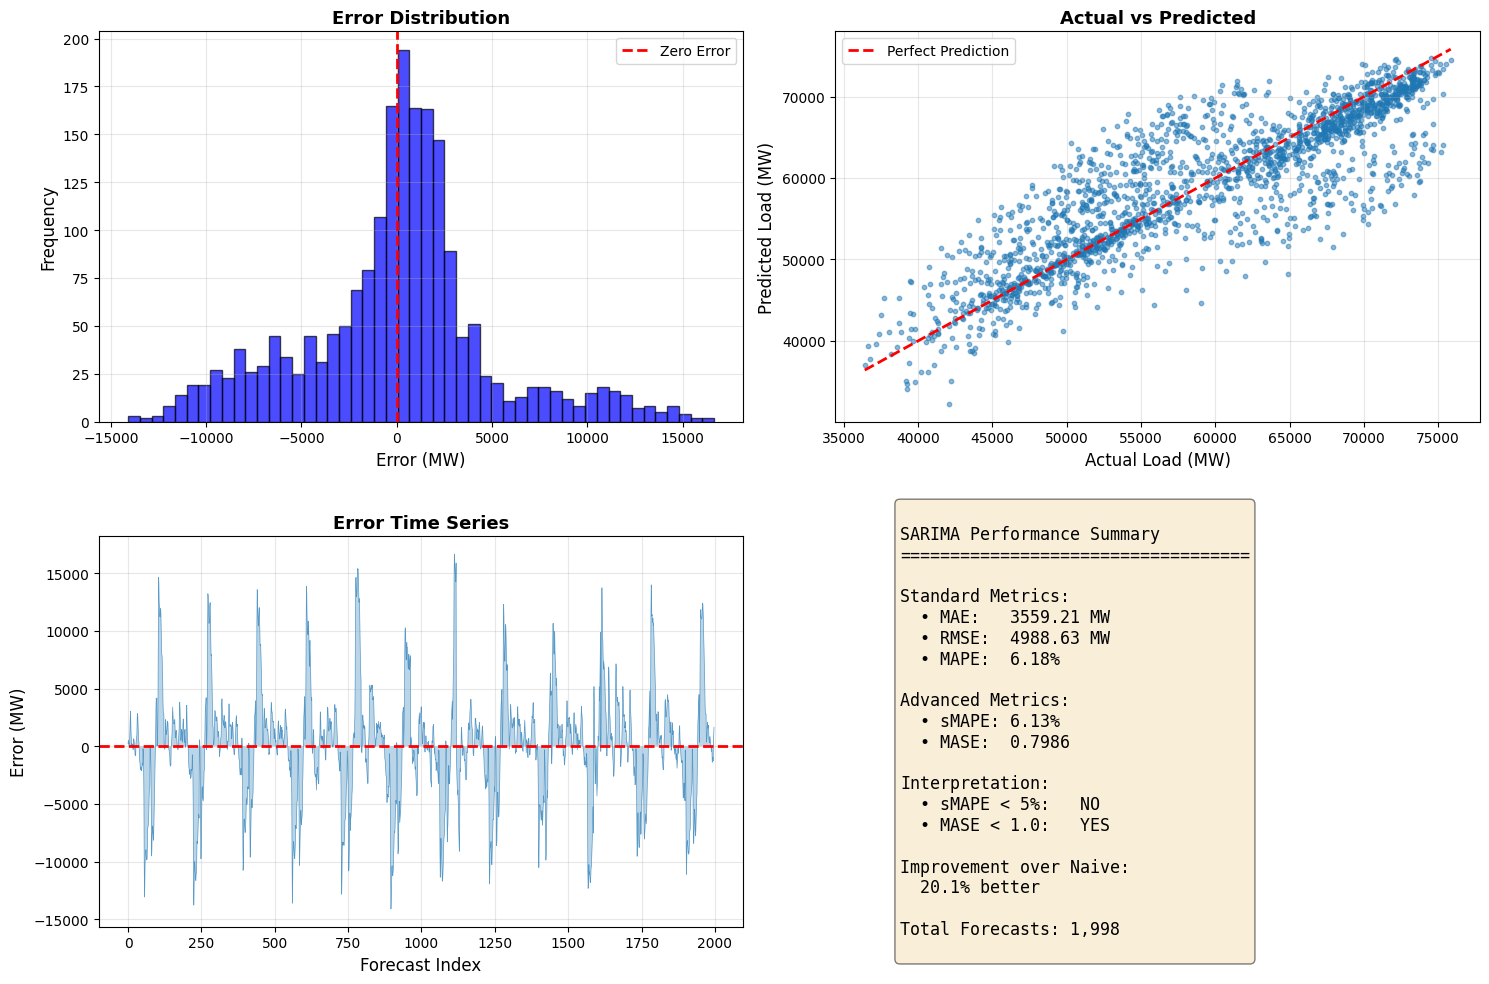


 Visualization saved to: ../outputs/sarima_performance_metrics.png


In [51]:
# Visualize error distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Error histogram
axes[0, 0].hist(errors, bins=50, edgecolor='black', alpha=0.7, color='blue')
axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[0, 0].set_xlabel('Error (MW)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Error Distribution', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Actual vs Predicted scatter
axes[0, 1].scatter(y_true, y_pred, alpha=0.5, s=10)
axes[0, 1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 1].set_xlabel('Actual Load (MW)', fontsize=12)
axes[0, 1].set_ylabel('Predicted Load (MW)', fontsize=12)
axes[0, 1].set_title('Actual vs Predicted', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Time series of errors
axes[1, 0].plot(errors, linewidth=0.5, alpha=0.7)
axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1, 0].fill_between(range(len(errors)), errors, 0, alpha=0.3)
axes[1, 0].set_xlabel('Forecast Index', fontsize=12)
axes[1, 0].set_ylabel('Error (MW)', fontsize=12)
axes[1, 0].set_title('Error Time Series', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Metrics summary as text
axes[1, 1].axis('off')
metrics_text = f"""
SARIMA Performance Summary
{'='*35}

Standard Metrics:
  • MAE:   {mae:.2f} MW
  • RMSE:  {rmse:.2f} MW
  • MAPE:  {mape:.2f}%

Advanced Metrics:
  • sMAPE: {smape:.2f}%
  • MASE:  {mase:.4f}

Interpretation:
  • sMAPE < 5%:  {' YES' if smape < 5 else ' NO'}
  • MASE < 1.0:  {' YES' if mase < 1 else ' NO'}
  
Improvement over Naive:
  {((1 - mase) * 100):.1f}% better

Total Forecasts: {len(y_true):,}
"""
axes[1, 1].text(0.1, 0.5, metrics_text, fontsize=12, family='monospace',
                verticalalignment='center', bbox=dict(boxstyle='round', 
                facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('../outputs/sarima_performance_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Visualization saved to: ../outputs/sarima_performance_metrics.png")

## 17. Multi-Country SARIMA Performance Comparison

In [52]:
def calculate_metrics(country_code):
    """Calculate all metrics for a given country"""
    # Load live forecasts
    live_file = f'../outputs/{country_code}_live_forecasts.csv'
    df_live = pd.read_csv(live_file, parse_dates=['timestamp']).dropna(subset=['y_true', 'yhat'])
    
    y_true = df_live['y_true'].values
    y_pred = df_live['yhat'].values
    errors = y_true - y_pred
    
    # Standard metrics
    mae = np.abs(errors).mean()
    rmse = np.sqrt((errors**2).mean())
    mape = (np.abs(errors / y_true) * 100).mean()
    
    # sMAPE
    smape = (100 / len(y_true)) * np.sum(
        np.abs(y_pred - y_true) / ((np.abs(y_true) + np.abs(y_pred)) / 2)
    )
    
    # MASE
    data_file = f'../data/{country_code}.csv'
    df_data = pd.read_csv(data_file, parse_dates=['timestamp'], index_col='timestamp')
    naive_errors = df_data['load'].diff(24).dropna()
    mae_naive = np.abs(naive_errors).mean()
    mase = mae / mae_naive if mae_naive > 0 else np.nan
    
    return {
        'Country': country_code,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'sMAPE': smape,
        'MASE': mase,
        'N_Forecasts': len(y_true)
    }

# Calculate for all countries
countries = ['DE', 'FR', 'ES']
results = []

for country in countries:
    try:
        metrics = calculate_metrics(country)
        results.append(metrics)
        print(f" {country}: Metrics calculated")
    except Exception as e:
        print(f" {country}: Error - {str(e)}")

# Create comparison DataFrame
comparison_df = pd.DataFrame(results)
print("\n" + "="*80)
print(" "*25 + "SARIMA PERFORMANCE COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

 DE: Metrics calculated
 FR: Metrics calculated
 ES: Metrics calculated

                         SARIMA PERFORMANCE COMPARISON
Country         MAE        RMSE     MAPE    sMAPE     MASE  N_Forecasts
     DE 3559.211352 4988.632684 6.182132 6.129303 0.798589         1998
     FR 3030.451581 4259.932751 4.999560 5.028565 0.975617         1979
     ES 1499.490196 2181.769710 5.195996 5.119566 0.832057         1996


In [31]:
# Add model architecture info to comparison
sarima_models = {
    'DE': 'SARIMA(2,1,2)(1,1,1,24)',
    'FR': 'SARIMA(1,1,1)(1,1,1,24)',
    'ES': 'SARIMA(1,1,1)(1,1,1,24)'
}

print(f"\n Countries to save: {list(comparison_df['Country'].unique())}")
print(f"Number of countries: {len(comparison_df)}")

# Load existing metrics_summary.csv
metrics_file = '../outputs/metrics_summary.csv'
existing_metrics = pd.read_csv(metrics_file)

print(f"\n Current metrics_summary.csv has {len(existing_metrics)} rows")
print(f"Existing countries: {existing_metrics['country'].unique().tolist()}")
print(f"Existing splits: {existing_metrics['split'].unique().tolist()}")

# Create SARIMA entries for all countries
sarima_entries = []
for _, row in comparison_df.iterrows():
    entry = {
        'country': row['Country'],
        'split': 'sarima_live',
        'MASE': row['MASE'],
        'sMAPE': row['sMAPE'],
        'RMSE': row['RMSE'],
        'MAPE': row['MAPE'],
        'MSE': row['RMSE']**2,
        'Coverage (80%)': np.nan
    }
    sarima_entries.append(entry)
    print(f"  → Preparing {row['Country']}: MASE={row['MASE']:.4f}, sMAPE={row['sMAPE']:.2f}%")

sarima_df = pd.DataFrame(sarima_entries)

print(f"\n Created {len(sarima_df)} new SARIMA entries:")
print(sarima_df[['country', 'split', 'MASE', 'sMAPE']].to_string(index=False))

# Remove any existing SARIMA entries to avoid duplicates
existing_metrics = existing_metrics[existing_metrics['split'] != 'sarima_live']
print(f"\n Removed existing sarima_live entries (if any)")

# Append new SARIMA metrics
updated_metrics = pd.concat([existing_metrics, sarima_df], ignore_index=True)

# Sort by country and split for better organization
updated_metrics = updated_metrics.sort_values(['country', 'split']).reset_index(drop=True)

# Save back to the same file
updated_metrics.to_csv(metrics_file, index=False)

print(f"\n All {len(sarima_df)} SARIMA metrics saved to: ../outputs/metrics_summary.csv")
print(f" Total rows in file: {len(updated_metrics)}")
print("\n" + "="*90)
print("UPDATED metrics_summary.csv (showing sarima_live entries):")
print("="*90)
print(updated_metrics[updated_metrics['split'] == 'sarima_live'].to_string(index=False))
print("="*90)

# Also create a detailed comparison DataFrame for display
comparison_df['Model'] = comparison_df['Country'].map(sarima_models)
comparison_df['Improvement_vs_Naive_%'] = (1 - comparison_df['MASE']) * 100
comparison_df = comparison_df[['Country', 'Model', 'MAE', 'RMSE', 'MAPE', 'sMAPE', 'MASE', 
                                'Improvement_vs_Naive_%', 'N_Forecasts']]

print("\n" + "="*90)
print("DETAILED SARIMA COMPARISON")
print("="*90)
print(comparison_df.to_string(index=False))
print("="*90)


 Countries to save: ['DE', 'FR', 'ES']
Number of countries: 3

 Current metrics_summary.csv has 7 rows
Existing countries: ['DE', 'FR', 'ES']
Existing splits: ['dev', 'test', 'sarima_live']
  → Preparing DE: MASE=0.7986, sMAPE=6.13%
  → Preparing FR: MASE=0.9756, sMAPE=5.03%
  → Preparing ES: MASE=0.8321, sMAPE=5.12%

 Created 3 new SARIMA entries:
country       split     MASE    sMAPE
     DE sarima_live 0.798589 6.129303
     FR sarima_live 0.975617 5.028565
     ES sarima_live 0.832057 5.119566

 Removed existing sarima_live entries (if any)

 All 3 SARIMA metrics saved to: ../outputs/metrics_summary.csv
 Total rows in file: 9

UPDATED metrics_summary.csv (showing sarima_live entries):
country       split     MASE    sMAPE        RMSE     MAPE          MSE  Coverage (80%)
     DE sarima_live 0.798589 6.129303 4988.632684 6.182132 2.488646e+07             NaN
     ES sarima_live 0.832057 5.119566 2181.769710 5.195996 4.760119e+06             NaN
     FR sarima_live 0.975617 5.028565

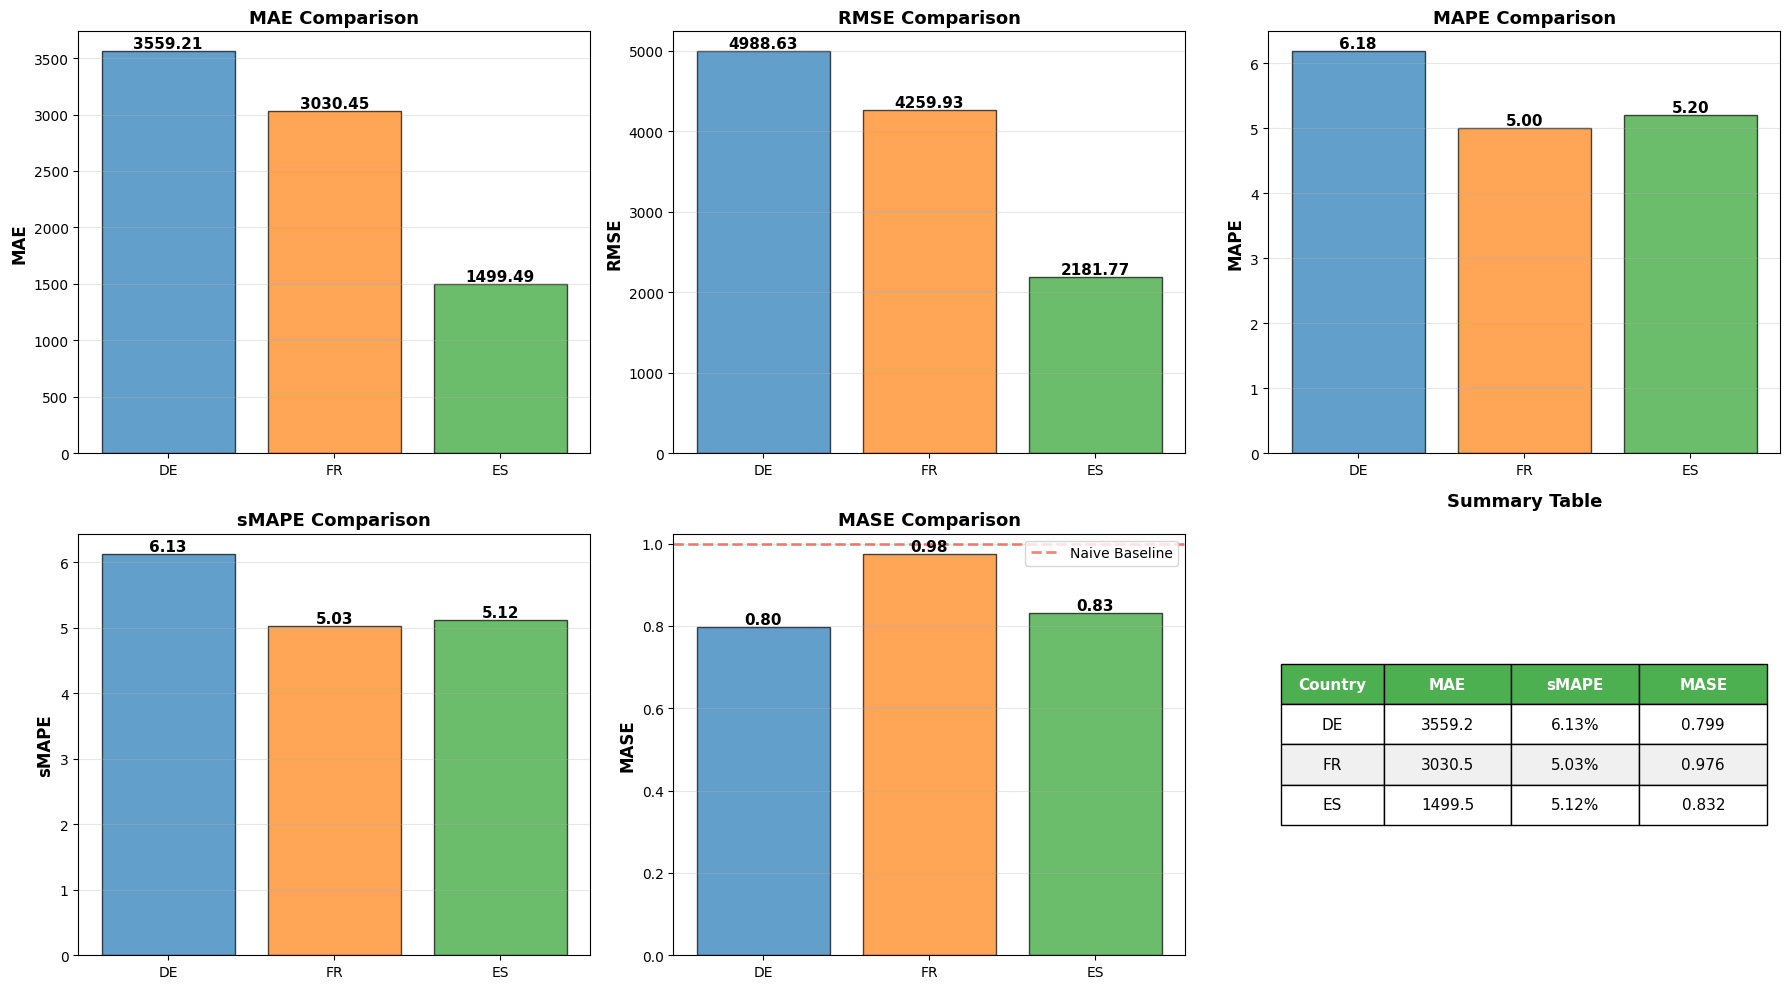

In [53]:
# Visualize comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

metrics_to_plot = ['MAE', 'RMSE', 'MAPE', 'sMAPE', 'MASE']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, metric in enumerate(metrics_to_plot):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    values = comparison_df[metric].values
    bars = ax.bar(comparison_df['Country'], values, color=colors, alpha=0.7, edgecolor='black')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Special annotations
    if metric == 'MASE':
        ax.axhline(1.0, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Naive Baseline')
        ax.legend()

# Add summary table in the last subplot
ax = axes[1, 2]
ax.axis('off')

table_data = []
for _, row in comparison_df.iterrows():
    table_data.append([
        row['Country'],
        f"{row['MAE']:.1f}",
        f"{row['sMAPE']:.2f}%",
        f"{row['MASE']:.3f}"
    ])

table = ax.table(cellText=table_data,
                 colLabels=['Country', 'MAE', 'sMAPE', 'MASE'],
                 cellLoc='center',
                 loc='center',
                 colWidths=[0.2, 0.25, 0.25, 0.25])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)

# Style header
for i in range(4):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Style cells
for i in range(1, len(table_data) + 1):
    for j in range(4):
        table[(i, j)].set_facecolor('#f0f0f0' if i % 2 == 0 else 'white')

ax.set_title('Summary Table', fontsize=13, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('../outputs/sarima_multi_country_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

